In [15]:
from itertools import combinations
import qiskit
import numpy as np
import tqix
import sys


def generate_u_pauli(num_qubits):
    lis = [0, 1, 2]
    coms = []
    if num_qubits == 2:
        for i in lis:
            for j in lis:
                coms.append([i, j])
    if num_qubits == 3:
        for i in lis:
            for j in lis:
                for k in lis:
                    coms.append([i, j, k])
    if num_qubits == 4:
        for i in lis:
            for j in lis:
                for k in lis:
                    for l in lis:
                        coms.append([i, j, k, l])
    if num_qubits == 5:
        for i in lis:
            for j in lis:
                for k in lis:
                    for l in lis:
                        for m in lis:
                            coms.append([i, j, k, l, m])
    sigma = [tqix.sigmax(), tqix.sigmay(), tqix.sigmaz()]
    Us = []
    for com in coms:
        U = sigma[com[0]]
        for i in range(1, num_qubits):
            U = np.kron(U, sigma[com[i]])
        Us.append(U)
    
    return Us[: 3**num_qubits]


def create_basic_vector(num_qubits: int):
    """Generate list of basic vectors

    Args:
        num_qubits (int): number of qubits

    Returns:
        np.ndarray: |00...0>, |00...1>, ..., |11...1>
    """
    bs = []
    for i in range(0, 2**num_qubits):
        b = np.zeros((2**num_qubits, 1))
        b[i] = 1
        bs.append(b)
    return bs


def calculate_sigma(U: np.ndarray, b: np.ndarray):
    """Calculate measurement values

    Args:
        U (np.ndarray): operator
        b (np.ndarray): basic vector

    Returns:
        np.ndarray: sigma operator
    """
    return (np.conjugate(np.transpose(U)) @ b @ np.conjugate(np.transpose(b)) @ U)

# def calculate_mu(density_matrix):
#     M = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
#     for i in range(0, num_observers):
#         for j in range(0, 2**num_qubits):
#             k = sigmass[i][j]
#             M += np.trace(k @ density_matrix) * k
#     M /= num_observers
#     return M


def calculate_mu_inverse(density_matrix, num_qubits):
    k = 3*density_matrix - \
        np.trace(density_matrix) * np.identity(2 **
                                               num_qubits, dtype=np.complex128)
    # M = k.copy()
    # for i in range(1, num_qubits):
    #     M = np.kron(M, k)
    return k
def self_tensor(matrix, n):
    product = matrix
    for i in range(1, n):
        product = np.kron(product, matrix)
    return product


In [16]:
num_qubits = 4
psi = 2*np.random.rand(2**num_qubits)
psi = psi / np.linalg.norm(psi)
rho = qiskit.quantum_info.DensityMatrix(psi).data

def shadow(num_experiments):

    num_observers = 3**num_qubits
    Us, bs = [], []
    bs = create_basic_vector(num_qubits)
    Us = generate_u_pauli(num_qubits)
    count_i = [0] * (num_observers)
    sum_b_s = [np.zeros((2**num_qubits, 2**num_qubits),
                        dtype=np.complex128)] * (num_observers)
    for i in range(0, num_experiments):
        r = np.random.randint(0, num_observers)
        count_i[r] += 1
        U = Us[r]
        sum_b = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
        for j in range(0, 2**num_qubits):
            k = calculate_sigma(U, bs[j])
            sum_b_s[r] += np.trace(k @ rho)*calculate_mu_inverse(k, num_qubits)
            temp = sum_b_s[r].copy()
            sum_b_s[r] = (np.conjugate(np.transpose(
                temp)) @ temp) / (np.trace(np.conjugate(np.transpose(temp)) @ temp))

    ps = np.zeros(num_observers)
    rho_hat = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    rho_hat_variant = 0
    for i in range(0, num_observers):
        ps[i] = count_i[i] / num_experiments
        traceA = np.trace(self_tensor(tqix.sigmaz(), num_qubits) @ sum_b_s[i])
        traceB = np.trace(self_tensor(tqix.sigmaz(), num_qubits) @ rho)
        rho_hat_variant += ps[i] * (traceA - traceB)**2
        rho_hat += ps[i] * sum_b_s[i]
        return rho_hat_variant, rho_hat
# new_rho_hat = (np.conjugate(np.transpose(
#     rho_hat)) @ rho_hat) / (np.trace(np.conjugate(np.transpose(rho_hat)) @ rho_hat))
# fidelity = qtm.base.trace_fidelity(rho, new_rho_hat)
# trace = qtm.base.trace_distance(rho, new_rho_hat)
#     return trace, fidelity, rho, new_rho_hat

# traces = []
# fidelities = []
# rho_hats = []
# for i in range(0, 1):
#     trace, fidelity, rho, new_rho_hat = shadow_tomo()
#     traces.append(trace)
#     fidelities.append(fidelity)
#     rho_hats.append(new_rho_hat.copy())

# print(np.mean(traces))
# print(np.mean(fidelities))
# print(np.std(traces))
# print(np.std(fidelities))
# min_rho_hat = (rho_hats[np.argmin(traces)])


In [17]:
rho_hat_variantss = []
noe_large = [10**2, 10**3, 10**4, 10**5]
for noe in noe_large:
    rho_hat_variants = []
    for i in range(0, 10):
        rho_hat_variant, rho_hat = shadow(noe)
        rho_hat_variants.append(rho_hat_variant)
    rho_hat_variantss.append(rho_hat_variants)


In [18]:
np.savetxt("./rho_hat_variantss" + str(num_qubits) + ".csv",
           rho_hat_variantss,
           delimiter=",")

averages_var = [0]*4
averages_std = [0]*4
for i in range(len(noe_large)):
    averages_var[i] = np.mean(rho_hat_variantss[i])
    averages_std[i] = np.std(rho_hat_variantss[i])
print(averages_var)
print(averages_std)


[(0.008687697988279635+0j), (0.009658731787962236+0j), (0.008910386952710084+0j), (0.00971607342606371+0j)]
[0.0063233555101296236, 0.002370011341539773, 0.0005752209842798887, 0.0019561615997392896]


C:\Users\HAI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


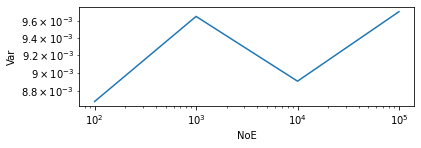

In [19]:
import matplotlib.pyplot as plt

plt.plot(noe_large, averages_var)
plt.subplot(2, 1, 1)
plt.plot(noe_large, averages_var)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('NoE')
plt.ylabel('Var')
plt.show()


L = 2, W_chain, Adam

Calculate $var(Z\otimes Z) = (\langle\tilde{\psi}|ZZ|\tilde{\psi}\rangle^2 - \langle\psi|ZZ|\psi\rangle^2)$


In [20]:

import sys
sys.path.insert(1, '../')
import qtm.fubini_study
import qtm.nqubit
import qtm.base
num_layers = 2
thetas = np.ones(num_layers*num_qubits*4)

qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
qc.initialize(psi, range(0, num_qubits))

loss_values = []
thetass = []

for i in range(0, 400):
    if i % 20 == 0:
        print('W_chain: (' + str(num_layers) +
              ',' + str(num_qubits) + '): ' + str(i))

    grad_loss = qtm.base.grad_loss(
        qc,
        qtm.nqubit.create_Wchain_layerd_state,
        thetas, r=1/2, s=np.pi/2, num_layers=num_layers)
    if i == 0:
        m, v = list(np.zeros(thetas.shape[0])), list(
            np.zeros(thetas.shape[0]))
    thetas = qtm.optimizer.adam(thetas, m, v, i, grad_loss)
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Wchain_layerd_state(
        qc.copy(), thetas, num_layers)
    loss = qtm.loss.loss_basis(qtm.base.measure(
        qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


W_chain: (2,4): 0
W_chain: (2,4): 20
W_chain: (2,4): 40
W_chain: (2,4): 60
W_chain: (2,4): 80
W_chain: (2,4): 100
W_chain: (2,4): 120
W_chain: (2,4): 140
W_chain: (2,4): 160
W_chain: (2,4): 180
W_chain: (2,4): 200
W_chain: (2,4): 220
W_chain: (2,4): 240
W_chain: (2,4): 260
W_chain: (2,4): 280
W_chain: (2,4): 300
W_chain: (2,4): 320
W_chain: (2,4): 340
W_chain: (2,4): 360
W_chain: (2,4): 380


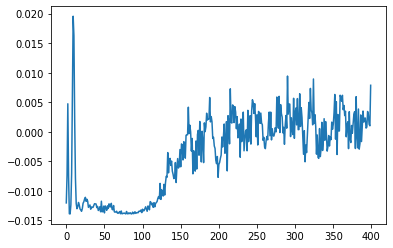

In [21]:
variances = []
for thetas in thetass:
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Wchain_layerd_state(
        qc, thetas, num_layers=num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc).data
    variances.append((np.conjugate(np.transpose(psi_hat)) @ self_tensor(tqix.sigmaz(), num_qubits) @ psi_hat)
                     ** 2 - (np.conjugate(np.transpose(psi)) @ self_tensor(tqix.sigmaz(), num_qubits) @ psi)**2)
plt.plot(variances)

np.savetxt("./thetass"+ str(num_qubits) + ".csv",
           thetass,
           delimiter=",")
np.savetxt("./variances" + str(num_qubits) + ".csv",
           variances,
           delimiter=",")

In [22]:
min((abs(x), x) for x in variances)[1]


(-1.1931060156419523e-05+0j)

In [23]:
variances[-1]


(0.007868430229370768+0j)